In [1]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np

En este Notebook queremos estudiar la dinámica de un sistema cuántico simple de dos niveles de energía (ver imagen), con el objetivo de encontrar la ergotropía en el estado final cuando  $\epsilon = 0$. 

<img src='DQD.png'>

La imagen muestra el sistema: un doble punto cuántico acoplado a dos reservorios electrónicos, luego el problema se trata en el régimen nanoscópico y se apunta que la interacción entre los reservorios y el sistema cuántico es débil por lo cual el problema es modelado por la ecuación de Lindblad, además de imponer aproximaciones como la de banda ancha para permitir uni direccionalidad además también se impone bloqueo fuerte de Coulomb para imponer que como máximo un solo electrón este en el sistema. Vemos que la consecuencia directa de este caso, es el valor físico que toma el parámetro de acoplamiento $T_{c}$. 

Primero podemos empezar con represtar las matrices de pauli 
$$
\text{$\sigma $x}=\left(
\begin{array}{cc}
 0 & 1 \\
 1 & 0 \\
\end{array}
\right)
$$
$$\text{$\sigma $y}=\left(
\begin{array}{cc}
 0 & -i \\
 i & 0 \\
\end{array}
\right)
$$
$$
\text{$\sigma $z}=\left(
\begin{array}{cc}
 1 & 0 \\
 0 & -1 \\
\end{array}
\right)
$$
y los valores externos entre los estados del sistema en su forma matricial
$$
\text{$\sigma $R}=\left(
\begin{array}{ccc}
 0 & 0 & 1 \\
 0 & 0 & 0 \\
 0 & 0 & 0 \\
\end{array}
\right)
$$
$$
\text{$\sigma $L}=\left(
\begin{array}{ccc}
 0 & 0 & 0 \\
 1 & 0 & 0 \\
 0 & 0 & 0 \\
\end{array}
\right)
$$

In [2]:
#G,L,R son los estados en los que puede estar el electron 
G = 0
L = 1
R = 2
#Las matrices de pauli (sx,sy,sz) son construidas en la base de ocupación (L,R)
sz = projection(3, L, L) - projection(3, R, R)
sx = projection(3, L, R) + projection(3, R, L)
sy = -projection(3, L, R)*1j + projection(3, R, L)*1j
#Construimos los productos exteriores de los estados, para la construcción de los operadores de colapso sL=|L><0|, sR=|0><R|
sL = projection(3, L, G)
sR = projection(3, G, R) 

Definimos los valores de las tasas de frecuencia $\Gamma_R$, $\Gamma_L$, la constante de acoplamiento entre los niveles $T_c$ estas constantes son producto del tunelamiento que hacen los electrones para pasar de izquierda a derecha a traves de barreras de potenciales impuestos en la realización fisica del sistema.

In [3]:
#Definimos los parametros del sistema
gammaR = 0.1 
gammaL = 0.1  
tc = 0.1 
nth = 0.00001 

Los operadores colapso o de Lindblad (el estado colapsa de uno a otro y así es como hay transporte) se definen en función de los estados del sistema en la base de ocupación multiplicado por la raíz de los operadores de colapso, sea cual sea el caso (esta forma de operadores de colapso, se observan directamente de la derivación microscópica de la ecuación de Linblad): 
$$
 \hat{c}_{1}=\sqrt{\Gamma_{L}}|{L}\rangle\langle{0}|
$$

$$
\hat{c}_{2}=\sqrt{\Gamma_{R}}|{0}\rangle\langle{R}|
$$

$$
\hat{c}_{1}^{\dagger}=\sqrt{\Gamma_{L}}|{0}\rangle\langle{L}|
$$

$$
\hat{c}_{2}^{\dagger}=\sqrt{\Gamma_{R}}|{R}\rangle\langle{0}|
$$
Estos operadores son contrucciones necesarios para describir la evolucion del sistema mediante la ecuacion de Lindblad.


In [4]:
#operadores colapso (escalera), operadores c1,c2,c1(daga),c2(daga)
c_ops = [np.sqrt(gammaL * (1 + nth)) * sL,
         np.sqrt(gammaL * (nth)) * sL.dag(),
         np.sqrt(gammaR * (nth)) * sR.dag(),
         np.sqrt(gammaR * (1 + nth)) * sR,
         ]

Consideramos el hamiltiano de dos niveles que describe el doble punto cuántico acoplado, siendo $\sigma_{z},\sigma_{x}$ las matrices de Pauli en la base de ocupación:
$$
\hat{H}=\frac{1}{2}\epsilon \sigma_{z}+T_{c}\sigma_{x}
$$

Cuando $\epsilon=0$ el único parámetro que toma relevancia es el acoplamiento entre los puntos $T_{c}$:
$$
\hat{H}=T_{c}\sigma_{x}
$$

In [5]:
H = (tc * sx) #Hamiltoniano del sistema
psi0 =(1.0*basis(3,0)+0.0*basis(3,2)).unit() # Se define el estado inicial en la dinámica  
e_ops = [sx, sy,sz]# lista e_ops de las matrices de pauli

Gracias a Qutip la ecuación de Lindblad se puede definir mediante la función mesolve, y con los objetos cuánticos definidos atrás podemos solucionar la dinámica del sistema: $$
\dot{\rho}=-i[\hat{H},\hat{\rho}] + \textit{D}[\hat{c_{1}}]\hat{\rho}
           + \textit{D}[\hat{c_{1}}]\hat{\rho}
$$

In [6]:
tlist = np.linspace(0,100,1000)
result = mesolve(H, psi0, tlist, c_ops, e_ops) # Solucionamos la dinámica con mesolve (ecuación de Lindblad)
A,B,C=result.expect[0],result.expect[1],result.expect[2] #Obtenemos los valores esperados de sx,sy,sz

Con los valores esperados obtenemos la magnitud del vector de bloch.  
$$
r=\sqrt{X^2+Y^2+Z^2}
$$

In [7]:
D=np.sqrt(result.expect[0]**2 + result.expect[1]**2 + result.expect[2]**2)

En esta celda se utiliza un for para iterar sobre la variable $t_{ci}$ que seria el acoplamiento entre puntos hasta $tc_{vec}$ para asi poder contruir valores del hamiltoniano para cada tiempo y con ello contruir el Liovilliano, con el cual podemos determinar el estado estacionario con el que se construyen los valores esperados de las matrices de pauli en el estado estado estacionario.

In [8]:
tc_vec = np.linspace(0.01 * gammaR, 10 * gammaR, 1000) 
x = np.zeros(len(tc_vec)) # devuelve a la variable x un array con la longitud de la lista tc_vec repleta de 0
y = np.zeros(len(tc_vec)) #\\
z = np.zeros(len(tc_vec)) #\\
for n, tci in enumerate(tc_vec): 
    H = (tci * sx) # Hamiltoniano iterando en tci
    L = liouvillian(H, c_ops) # se cambia del espacio de Hilbert al espacio de Liouville
    rhoss = steadystate(L) # estado estacionario en el espacio de Liouville
    x[n]=expect(sx, rhoss) #se crea la variable x[n] que itera de n=0 hasta tc_vec, y calcula el valor esperado del operador sx en el EE
    y[n]=expect(sy, rhoss) #\\
    z[n]=expect(sz, rhoss) #\\

(-1.0, 1.0)

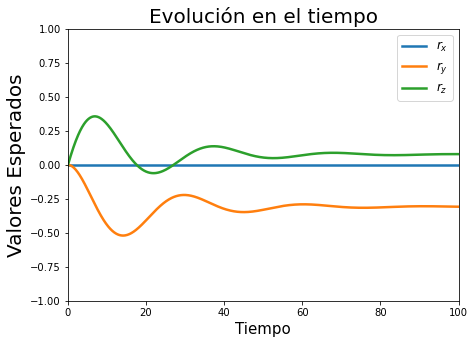

In [9]:
#Graficamos los valores esperados a través del tiempo
fig, axes = plt.subplots(1,1,figsize=(7,5))
axes.plot(result.times,result.expect[0], linewidth=2.5, linestyle="-")
axes.plot(result.times,result.expect[1], linewidth=2.5, linestyle="-")
axes.plot(result.times,result.expect[2], linewidth=2.5, linestyle="-")
axes.legend((r'$r_{x}$', r'$r_{y}$', r'$r_{z}$'),fontsize=12)
axes.set_xlabel('Tiempo',fontsize=15)
axes.set_ylabel('Valores Esperados',fontsize=20)
plt.title("Evolución en el tiempo",fontsize=20)
axes.set_xlim(left=np.min(x), right=(100))
axes.set_ylim(bottom=(-1), top=(1))

ya con los valores esperados tenemos el vector estacionario o el vector de bloch 
$$
r=\sqrt{X^2+Y^2+Z^2}
$$

(-0.027354015335511857, 1.0)

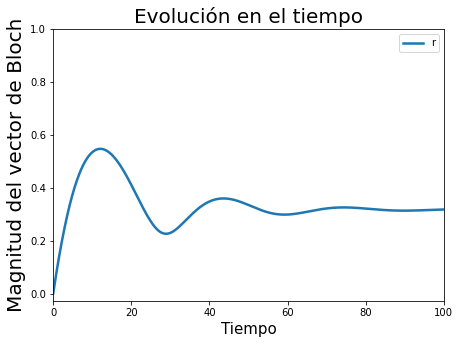

In [10]:
#Graficamos la magnitud de Bloch en el tiempo
fig, axes = plt.subplots(1,1,figsize=(7,5))
axes.plot(result.times,np.sqrt(result.expect[0]**2 + result.expect[1]**2 + result.expect[2]**2), linewidth=2.5, linestyle="-")
axes.legend(("r"))
axes.set_xlabel('Tiempo',fontsize=15)
axes.set_ylabel('Magnitud del vector de Bloch',fontsize=20)
plt.title("Evolución en el tiempo",fontsize=20)
axes.set_xlim(left=np.min(x), right=(100))
axes.set_ylim(top=(1))

PODEMOS VISUALIZAR EN LA ESFERA DE BLOCH EL VECTOR DE ESTADO ESTACIONARIO Y EL PUNTO DONDE EVOLUCIONA EL SISTEMA Y DONDE PODEMOS ENCONTRAR LA ERGOTROPIA

C:\Users\HP\anaconda3\lib\site-packages\qutip\bloch.py:752: RuntimeWarning: divide by zero encountered in true_divide
  if any(abs(dist - dist[0]) / dist[0] > 1e-12):
C:\Users\HP\anaconda3\lib\site-packages\qutip\bloch.py:752: RuntimeWarning: invalid value encountered in true_divide
  if any(abs(dist - dist[0]) / dist[0] > 1e-12):


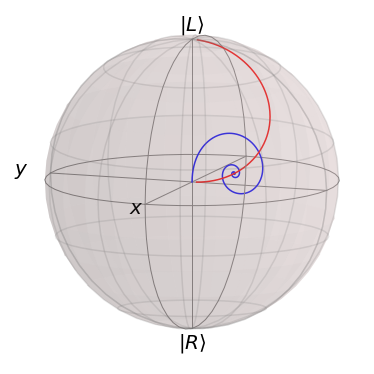

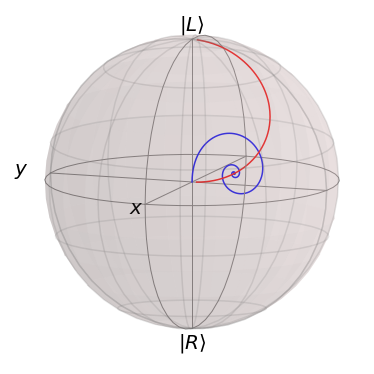

In [11]:
#Obtenemos una visualización en la esfera de Bloch del conjunto de estados estacionarios (rojo) y de la evolución del sistema (azul) 
sphere=Bloch()
sphere.add_points([result.expect[0],result.expect[1],result.expect[2]], meth='l')
sphere.add_points([x,y,z], meth='l')
sphere.zlabel = ['$\\left|L\\right>$','$\\left|R\\right> $']
sphere.zlpos = [1.1,-1.1] 
sphere.view = [70,-10]
sphere.show()

Cuando hablamos de cuantificar la coherencia, tenemos que pensar en una medida, ¿que tanta coherencia tiene el estado al cual evoluciono el sistema?. La medida de la coherencia mas ampliamente utilizada para operaciones libres IOs es la siguiente:

$$
C_{l1}=\sum_{i\neq j}|\rho_{ij}|
$$
es decir, que la medida de la coherencia es la suma de las no diagonales del operador densidad. 

Para poder representar la medida de la coherencia, se necesitan construir los elementos matriciales del operador de estado, sin embargo, como solo tenemos información de los valores esperados de las matrices de Pauli, se puede demoestrar que el operador de estado de un sistema de dos niveles puede ser reexpresado en funcion de estos valores esperados:

$$
\text{$\rho $}=\left(
\begin{array}{cc}
 \rho_{LL} & \rho_{LR} \\
 \rho_{RL} & \rho_{RR} \\
\end{array}
\right)=\frac{1}{2}\left(
\begin{array}{cc}
 1+\sigma z & \sigma x- i\sigma y \\
 \sigma x +i \sigma y & 1-\sigma z \\
\end{array}
\right)
$$


In [12]:
#contrucción de los elementos matriciales del operador densidad a partir de los valores esperados de las matrices de Pauli  
rhoLL=0.5*(1+C)
rhoRR=0.5*(1-C)
rhoLR=0.5*(A-1j*B)
rhoRL=0.5*(A+1j*B)

In [13]:
sx=range(len(A))
Coherencia=[]

In [14]:
for k in sx:
    A1=abs(rhoLR[k])
    A2=abs(rhoRL[k])
    Coh=A1+A2
    Coherencia.append(Coh)

(0.0, 1.0)

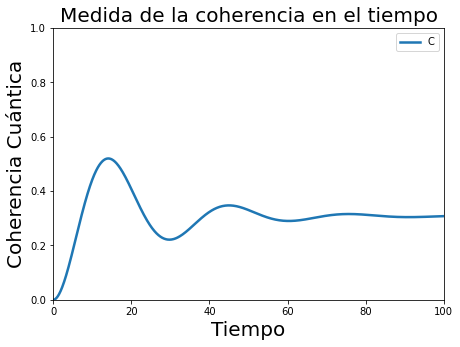

In [15]:
#Graficamos la medida de la coherencia en el tiempo
fig, axes = plt.subplots(1,1,figsize=(7,5))
axes.plot(tlist,Coherencia, linewidth=2.5, linestyle="-")
axes.legend(("CC"))
axes.set_xlabel('Tiempo',fontsize=20)
axes.set_ylabel('Coherencia Cuántica',fontsize=20)
plt.title("Medida de la coherencia en el tiempo",fontsize=20)
axes.set_xlim(left=np.min(x), right=(100))
axes.set_ylim(bottom=(0),top=(1))

Tambien graficaremos la ergotropía a traves del tiempo, de la siguiente expresion: 
$$
W=\frac{1}{2}r(\sqrt{4T_{c}^{2}+\epsilon^{2}}+\epsilon Z+2T_{c} X)
$$
considerando $\epsilon=0$ entonces:
$$
W=\frac{1}{2}(r\sqrt{4T_{c}^{2}}+2T_{c}r X)
$$
Obtuvimos tambien que $X=0$, llegando asi a la forma final: 
$$
W=\frac{1}{2}(r\sqrt{4T_{c}^{2}})=\frac{1}{2}(2rT_{c})=rT_{c}
$$

In [16]:
W=[]

In [17]:
for k in sx:
    Wo= tc*D[k]
    W.append(Wo)

(0.0, 100.0)

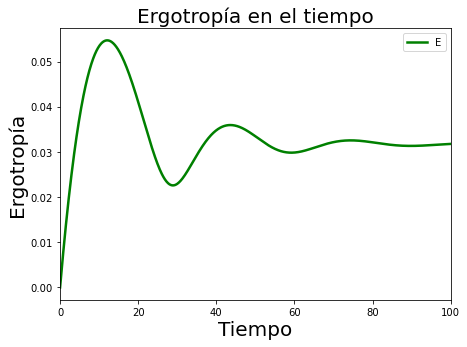

In [18]:
#Graficamos la Erogotropía en el tiempo 
fig, axes = plt.subplots(1,1,figsize=(7,5))
axes.plot(tlist,W, linewidth=2.5, linestyle="-",color="green")
axes.legend(("E"))
axes.set_xlabel('Tiempo',fontsize=20)
axes.set_ylabel('Ergotropía',fontsize=20)
plt.title("Ergotropía en el tiempo",fontsize=20)
axes.set_xlim(left=np.min(x), right=(100))